# Anticipez les besoins en consommation électrique de bâtiments

Nous cherchons à fournir une méthode plus économique de calcul de consommation d'énergie et d'émission de gaz à effet de serre. Pour ce faire, nous recherchons une architecture ML capable de prédire ces critères sur la base de caractéristiques intrinsèques au batiment. Les relevés énergétiques ne sont pas prit en compte dans ces calculs.

Au delà de cet objectif il nous est également demandé d'estimer l'utilité de l'EnergyStarScore dans la prédiction **d'émissions**

Ce notebook va aborder ces objectifs de la manière suivante :
1. Pré-traitement des données avant entrainement : découpage train /test et encodage
2. Analyse des variables 
* D'abord pour l'énergie, puis les émissions de gaz à effet de serre :
3. Entrainement de plusieurs types de modèles 
4. Analyse des différents modèles, leurs performances et feature importance
* Pour l'EnergyStar Score :
5. Construction de deux sous ensembles de données (avec et sans le feature en question)
6. Entrainement d'un modèle pour chaque sous ensemble et comparaison de leur performance
7. Estimation statistique de cette différence de performance

### Import des librairies nécessaires

In [805]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import timeit
import scipy
import sklearn
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from scipy import stats

Chargement des données

In [806]:
data = pd.read_csv('data_seattle_clean.csv',
                   sep='\t')

Découpage en set d'entrainement et de test

In [807]:
trainData, testData = train_test_split(data,
                                      test_size=0.2,
                                      random_state=10)

### Préparation des données pour l'apprentissage
Nous encodons les variables ordinales/catégorielles et standardisons les variables numériques.

In [808]:
trainData.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ENERGYSTARScore,815.0,NaN,NaN,NaN,64.083436,28.786436,1.0,46.0,71.0,89.0,100.0
ZipCode,1236.0,NaN,NaN,NaN,98116.347087,18.569971,98006.0,98104.0,98109.0,98122.0,98199.0
LargestPropertyUseType,1236,54,Office,397,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LargestPropertyUseTypeGFA,1236.0,NaN,NaN,NaN,91755.321197,162950.959811,5656.0,25200.0,41579.5,87663.25,1680937.0
TotalGHGEmissions,1236.0,NaN,NaN,NaN,165.488172,604.412062,-0.8,19.42,48.535,134.9225,12307.16
SiteEnergyUse(kBtu),1236.0,NaN,NaN,NaN,7637246.044203,19474769.944255,16808.90039,1204669.53125,2661771.125,6873718.5,293090784.0
NumberofBuildings,1236.0,NaN,NaN,NaN,1.031553,0.532179,0.0,1.0,1.0,1.0,9.0
numVoie,1236.0,NaN,NaN,NaN,2766.06877,3008.782301,2.0,700.0,1585.0,3938.75,14115.0
BuildingType,1236,3,NonResidential,1185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PrimaryPropertyType,1236,23,Small- and Mid-Sized Office,235,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Pour ce faire, nous créons des **listes** qui vont nous servir à **identifier** les différents types de variables.

Nous séparons les données catégorielles...

In [809]:
categorical = ['ZipCode',
               'LargestPropertyUseType',
               'CouncilDistrictCode',
               'Neighborhood',
               'PrimaryPropertyType',
               'BuildingType',
               'Voie']

des données ordinales...

In [810]:
ordinal = ['NumberofBuildings',
           'YearBuilt',
           'NumberofFloors']

et des données numériques

In [811]:
numerical = trainData.drop(categorical+ordinal,axis=1).columns.to_list()
numerical_notarget = numerical.copy()
numerical_notarget.remove('SiteEnergyUse(kBtu)')
numerical_notarget.remove('TotalGHGEmissions')
numerical_notarget.remove('ENERGYSTARScore')
print(numerical_notarget)

['LargestPropertyUseTypeGFA', 'numVoie', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'PropertyGFATotal', 'Longitude', 'Latitude']


### Analyse univariée
Nous allons observer les variables numériques afin de nous donner une idée de la forme de leurs distributions.

In [870]:
# cette fonction renvoie 'non' si la variable ne suit pas une distribution normale et 'oui' le cas inverse
def norm_test(values):
    k2, p = stats.normaltest(values)
    alpha = 0.05 
    if p < alpha:  # H0 data[column] est normale
        return 'non'
    else:
        return 'oui'

In [871]:
plt.style.use('seaborn-darkgrid')
def plot_summary(data):
    n_col = len(data.columns)
    fig, ax = plt.subplots(n_col,2,
                           figsize=(13,n_col*1.4),
                           gridspec_kw={'width_ratios':[6,1]})  
    title = plt.suptitle('Analyse univariée',
                fontsize=20)
    title.set_position([0.55,0.93])
    plt.subplots_adjust(hspace=0.8)
    ax[0,0].set_title('Distribution',fontsize=15)
    ax[0,1].set_title('Statistiques descriptives',fontsize=15)
    for i in range(0,n_col):
                   plot_data = data.iloc[:,i]
                   mean = np.round(plot_data.mean(),2)
                   median = np.round(plot_data.median(),2)
                   std = np.round(plot_data.std(),2)
                   is_norm = norm_test(plot_data)
                   sns.boxplot(ax = ax[i,0], x= plot_data)
                   y_stat = 0.85
                   ax[i,1].axis('off')
                   ax[i,1].text(s=f'moyenne = {mean}',x=-0.35,y=y_stat)
                   ax[i,1].text(s=f'écart-type = {std}',x=-0.35,y=y_stat-0.4)
                   ax[i,1].text(s=f'médiane = {median}',x=-0.35,y=y_stat-0.7)
                   ax[i,1].text(s=f'distribution normale = {is_norm}',x=-0.35,y=y_stat-1)

In [872]:
numericData = trainData.loc[:,numerical]

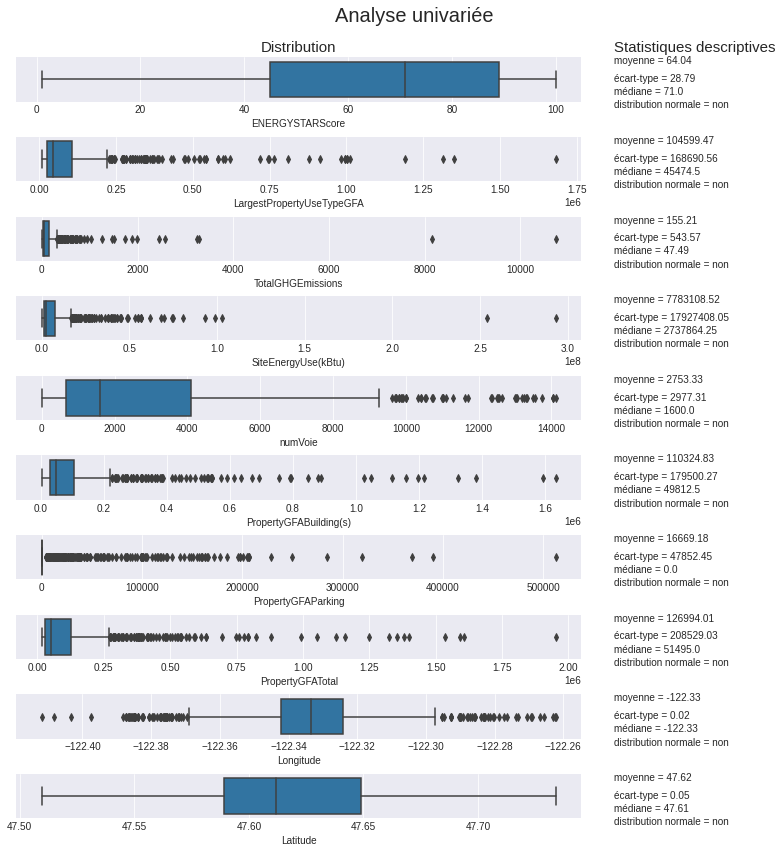

In [873]:
plot_summary(numericData)

Aucune de ces variables n'a de distribution normale et les différences d'échelles entre elles nous indiquent l'importance d'une standardisation avant l'entrainement.

## Analyse bivariée

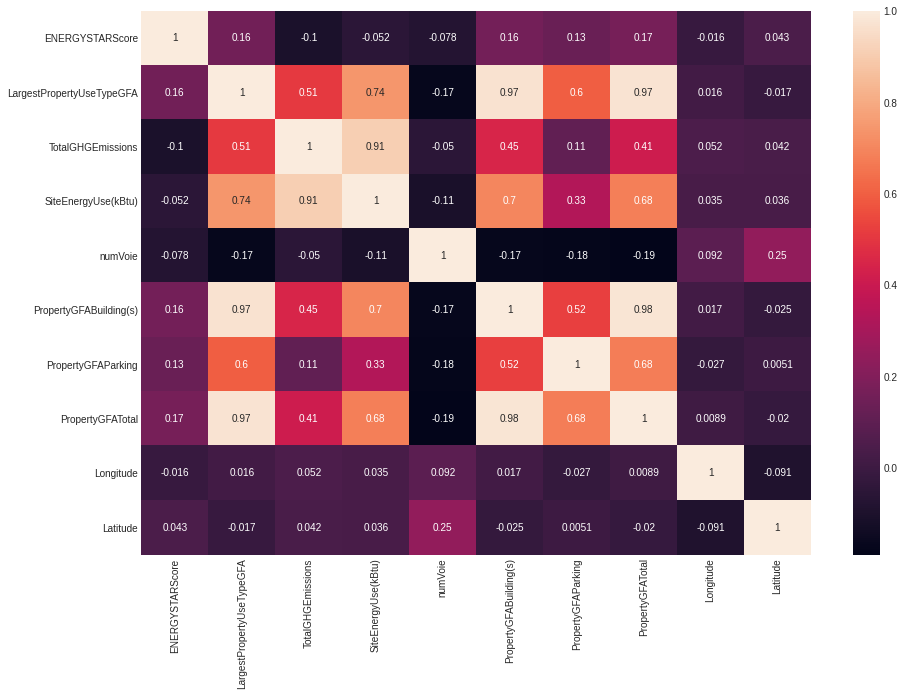

In [874]:
plt.figure(figsize=(15,10))
sns.heatmap(numericData.corr(),annot=True);

De manière générale il semblerait que la taille d'une propriété soit le déterminant majeur de sa consommation énergétique/ émission de gaz à effet de serre.

### Séparation des features des variables target
- Nous appliquons la même fonction au set train, validation et test

In [812]:
def cut_X_Y(data):
    Y_energy = data['SiteEnergyUse(kBtu)']
    Y_GHGE = data['TotalGHGEmissions']
    X = data.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1)
    X.drop('ENERGYSTARScore',axis=1,inplace=True)
    return Y_energy, Y_GHGE, X

In [813]:
Y_energy_train, Y_GHGE_train, X_train = cut_X_Y(trainData)
Y_energy_test, Y_GHGE_test, X_test = cut_X_Y(testData)

## Encodage des données 
Afin de rendre interprétables par les modèles des données non numériques nous procédons à une étape d'encodage.
- et afin de rendre interprétables pour nous les modèles, nous mettons en place une méthode de récupération des noms des features

In [814]:
# je n'ai pas écrit cette classe elle est disponible à l'addresse suivante :
# https://stackoverflow.com/questions/61079602/how-do-i-get-feature-names-using-a-column-transformer

# De base, columnTransformer renvoie une erreur lorsque l'on requête le nom des features 
# cette modification de la classe permet de renvoyer tous les noms de colonne 
class ColumnTransformerWithNames(ColumnTransformer):
        
        
    def get_feature_names(column_transformer):
        """Get feature names from all transformers.
        Returns
        -------
        feature_names : list of strings
            Names of the features produced by transform.
        """
        # Remove the internal helper function
        #check_is_fitted(column_transformer)

        # Turn loopkup into function for better handling with pipeline later
        def get_names(trans):
            # >> Original get_feature_names() method
            if trans == 'drop' or (
                    hasattr(column, '__len__') and not len(column)):
                return []
            if trans == 'passthrough':
                if hasattr(column_transformer, '_df_columns'):
                    if ((not isinstance(column, slice))
                            and all(isinstance(col, str) for col in column)):
                        return column
                    else:
                        return column_transformer._df_columns[column]
                else:
                    indices = np.arange(column_transformer._n_features)
                    return ['x%d' % i for i in indices[column]]
            if not hasattr(trans, 'get_feature_names'):
            # >>> Change: Return input column names if no method avaiable
                # Turn error into a warning
    #             warnings.warn("Transformer %s (type %s) does not "
    #                                  "provide get_feature_names. "
    #                                  "Will return input column names if available"
    #                                  % (str(name), type(trans).__name__))
                # For transformers without a get_features_names method, use the input
                # names to the column transformer
                if column is None:
                    return []
                else:
                    return [#name + "__" + 
                            f for f in column]

            return [#name + "__" + 
                    f for f in trans.get_feature_names()]

        ### Start of processing
        feature_names = []

        # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
        if type(column_transformer) == sklearn.pipeline.Pipeline:
            l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
        else:
            # For column transformers, follow the original method
            l_transformers = list(column_transformer._iter(fitted=True))


        for name, trans, column, _ in l_transformers: 
            if type(trans) == sklearn.pipeline.Pipeline:
                # Recursive call on pipeline
                _names = column_transformer.get_feature_names(trans)
                # if pipeline has no transformer that returns names
                if len(_names)==0:
                    _names = [#name + "__" + 
                              f for f in column]
                feature_names.extend(_names)
            else:
                feature_names.extend(get_names(trans))

        return feature_names
        
    def transform(self, X):
        indices = X.index.values.tolist()
        original_columns = X.columns.values.tolist()
        X_mat = super().transform(X)
        new_cols = self.get_feature_names()
        new_X = pd.DataFrame(X_mat.toarray(), index=indices, columns=new_cols)
        return new_X

    def fit_transform(self, X, y=None):
        super().fit_transform(X, y)
        return self.transform(X)

In [815]:
# Ici nous utilisons les listes de variables définies plus haut pour appliquer 
# les transformations adéquates à chaque variable
encoder = ColumnTransformerWithNames([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical_notarget),
    ('ord', OrdinalEncoder(handle_unknown='ignore'), ordinal),
])

Notre encodeur est modélisé seulement sur les données d'entrainement.

In [816]:
X_train_encoded = encoder.fit_transform(X_train)

Les données de test sont encodées par ce même modèle mais les modalités de variables qui n'ont jamais étés vues en entrainement ne sont pas prises en compte.

In [817]:
X_test_encoded = encoder.transform(X_test)

## Recherche du meilleur modèle : Consommation d'énergie 

### Passage au log
Le passage au log normalise la distribution et facilite l'apprentissage.

In [818]:
Y_energy_train_log = np.log(Y_energy_train)
Y_energy_test_log = np.log(Y_energy_test)

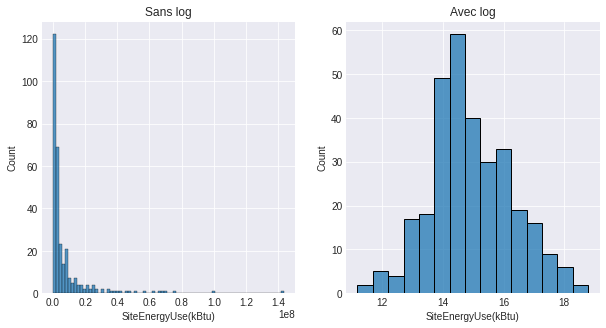

In [875]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.histplot(ax=ax[0],x=Y_energy_test)
ax[0].set_title('Sans log')
sns.histplot(ax=ax[1],x=Y_energy_test_log)
ax[1].set_title('Avec log');

## Entrainement

Nous construisons un dataframe de modèles. Ce dernier va nous permettre d'itérer dessus pour l'entrainement et faciliter la comparaison des modèles entre eux une fois l'apprentissage terminé.

In [820]:
# Les noms des modèles pour les graphiques
modelNames = ['Régression',
              'Régression ridge',
              'randomForest',
              'xgBoost']
# Les modèles à entrainer 
models = [LinearRegression(n_jobs=-1),
          Ridge(),
          RandomForestRegressor(n_jobs=-1),
          GradientBoostingRegressor()]

Définition des hyperparamètres

In [821]:
lineParameters = {}
ridgeParameters = {'alpha':np.logspace(-5,5,30)}

randomForestParameters = {'n_estimators' : [5,10,50,100,200],
                          'min_samples_leaf' : [1,3,5,10],
                          'max_features': ['auto', 'sqrt',10,20,30,40,50,70,80,90,100],
                          'max_samples':[0.1,0.2,0.3,0.4,0.5,0.7,0.8,1]}

xgBoostParameters = {'learning_rate':[0.1,0.2, 0.3,0.4,0.5], 
                     'max_depth':[2, 3, 4, 5], 
                     'n_estimators':[10,20,50,100]}

In [822]:
# Tout comme les modèles et leurs noms nous organisons les hyperparamètres en une liste pour le dataframe
hyperParameters = [lineParameters,
                   ridgeParameters,
                   randomForestParameters,
                   xgBoostParameters]

In [823]:
# Construction du dataframe
modelsDF = pd.DataFrame({'modelName':modelNames,
                         'model':models,
                         'hyperParameters':hyperParameters})

### Définition de la classe Model

Afin de simplifier la procédure d'entrainement qui va se répéter, nous définissons une classe qui comprend les étapes suivantes:
- Entrainement d'un modèle avec les paramètres par défaut
- Extraction de l'importance des features et mise à l'écart des prédicteurs moins utiles
- HyperParameter tuning 
- Prédiction sur données test et mesure de la performance
- Construction d'un graphique d'informations utiles sur le modèle

In [824]:
class Model:
# L'initialisation de la classe démarre l'entrainement du modèle
    def __init__(self,model,modelName,Xtrain,Ytrain,Xval,Yval,params):
        self.modelName = modelName
        
# Un premier entrainement sur paramètres par défaut est opéré
        model.fit(Xtrain,Ytrain)
    
# Ce modèle sert à extraire l'importance des features pour retirer ceux en dessous de la médiane
        self.featureSelector = SelectFromModel(model,threshold='median')
        self.featureSelector.fit(Xtrain,Ytrain)
        self.XtrainPruned =  self.featureSelector.transform(Xtrain)
        self.XvalPruned =  self.featureSelector.transform(Xval)
        
# Une fois le tri effectué nous récupérons le nom des features sélectionnés
        self.featureNames = Xtrain.columns[self.featureSelector.get_support()]
    
# HyperParameter tuning par validation croisée
        self.grid = GridSearchCV(model,
                            param_grid=params,
                            n_jobs=-1,
                            scoring='r2')
        self.tunedModel = self.grid.fit(self.XtrainPruned,Ytrain)   
        
# Nous prédisons, avec le modèle, sur les données d'entrainement et de test
        self.predictedTrain =  self.grid.predict(self.XtrainPruned)
    
# Le temps de prédiction sur les données test est mesuré
        self.startTime = timeit.default_timer()
        self.predictedValidation =  self.grid.predict(self.XvalPruned)
        self.tempsPrediction = timeit.default_timer() -  self.startTime
        
# Stockage des valeurs à comparer        
        self.data = {'YtrainTrue':Ytrain.values,
                     'YtrainPredict':self.predictedTrain,
                     'YvalTrue':Yval.values,
                     'YvalPredict':self.predictedValidation}
    
# stockage des métriques de performance du modèle             
        self.performance = {'RMSEtrain':np.sqrt(mean_squared_error(Ytrain,self.predictedTrain)),
                            'RMSEvalidation':np.sqrt(mean_squared_error(Yval,self.predictedValidation)),
                            'R2train':r2_score(Ytrain,self.predictedTrain),
                            'R2validation':r2_score(Yval,self.predictedValidation),
                            'tempsPrediction':self.tempsPrediction}
    
# calcul de l'importance des features par permutation
        self.importance = permutation_importance(self.tunedModel,
                                                 self.XtrainPruned,
                                                 Ytrain,
                                                 n_jobs=-1).importances_mean 
    
# stockage de l'importance dans un dataframe pour affichage graphique et tri descendant
        self.importanceDF = pd.DataFrame({'feature':self.featureNames,
                                          'importance':self.importance}).sort_values("importance",ascending=False)
        self.importanceDF.reset_index(drop=True,inplace=True)
        
# Fonction d'affichage du graphique_________________________________________________________
    def plot_summary(self):
        plt.style.use('seaborn-darkgrid')
        fig, ax = plt.subplots(3,2,
                       figsize=(14,14),
                      gridspec_kw={'height_ratios':[1,1,1],
                                   'width_ratios':[1,0.2]})
        plt.subplots_adjust(hspace=0.5)

        plt.suptitle(f'Résumé du modèle {self.modelName}',fontsize=30,y=0.95)

        sns.barplot(ax=ax[0,0],x="importance",y='feature',data=self.importanceDF.iloc[0:10,:])
        ax[0,0].set_ylabel('Features',fontsize=15)
        ax[0,0].set_xlabel('Importance',fontsize=15)

        sns.residplot(x = self.data['YtrainTrue'],
                      y = self.data['YtrainPredict'],
                      lowess=True,
                      line_kws={'color': 'red', 'lw': 2, 'alpha': 0.7} ,
                      ax=ax[1,0])
        sns.residplot(x = self.data['YvalTrue'],
                      y = self.data['YvalPredict'],
                      line_kws={'color': 'red', 'lw': 2, 'alpha': 0.7} ,
                      lowess=True,
                      ax=ax[2,0])
        ax[0,0].set_title('Importance des features', fontsize=18)
        ax[1,0].set_title('Résidus entrainement', fontsize=18)
        ax[2,0].set_title('Résidus validation', fontsize=18)

        for i in range(1,3):
            ax[i,0].set_xlabel('Valeurs réelles',fontsize=15)
            ax[i,0].set_ylabel('Résidus',fontsize=15)
        for i in range(0,3):
            ax[i,1].axis('off')

        Ypos = 0.95
        perfY = 0.9

        ax[0,1].text(s='HyperParamètres: ',
                     x=-0.4,
                     y=perfY,
                     fontsize=15)
        displayData = zip(list(self.grid.best_params_.keys()),list(self.grid.best_params_.values()))
        for key,value in displayData:
            perfY -= 0.1
            ax[0,1].text(s=f'{key} : {value}',
                         x=-0.4,
                         y=perfY)
            
        for i in range(1,3):
            ax[i,1].text(s='Performances: ',
                         x=-0.4,
                         y=Ypos,
                         fontsize=15)
        ax[1,1].text(s=f'RMSE: {self.performance["RMSEtrain"]:.3}',
                     x=-0.4,
                     y=Ypos - 0.2,
                     fontsize=12)
        ax[1,1].text(s=f'R2: {self.performance["R2train"]:.3}',
                     x=-0.4,
                     y=Ypos - 0.4,
                     fontsize=12)    
        ax[2,1].text(s=f'RMSE: {self.performance["RMSEvalidation"]:.3}',
                     x=-0.4,
                     y=Ypos - 0.2,
                     fontsize=12)
        ax[2,1].text(s=f'R2: {self.performance["R2validation"]:.3}',
                     x=-0.4,
                     y=Ypos - 0.4,
                     fontsize=12)
        ax[2,1].text(s=f'Temps Prédiction: {self.performance["tempsPrediction"]:.3} s',
                     x=-0.4,
                     y=Ypos - 0.6,
                     fontsize=12)

## Entrainement des modèles

Nous entrainons un dummy regressor pour nous donner une idée de la plus value de nos modèles.

In [825]:
# "Entrainement" du dummy regressor
dummyEnergy = DummyRegressor(strategy="mean")
dummyEnergy.fit(X_train_encoded,Y_energy_train)
# mesure du temps de prédiction
starTimeEnergyDummy = timeit.default_timer()
dummyPredictionEnergy = dummyEnergy.predict(X_test_encoded)
predictTimeEnergyDummy =  timeit.default_timer() - starTimeEnergyDummy 
# évatuation des performances
dummyEnergyRMSE = np.sqrt(mean_squared_error(Y_GHGE_test,dummyPredictionEnergy))
dummyEnergyR2 = r2_score(Y_GHGE_test,dummyPredictionEnergy)

Les autres modèles sont entrainés dans une boucle.

In [826]:
objModelsEnergy = []
for i in range(0,modelsDF.shape[0]):
    modelObject = Model(modelsDF['model'][i],
                        modelsDF['modelName'][i],
                        X_train_encoded,
                        Y_energy_train_log,
                        X_test_encoded,
                        Y_energy_test_log,
                        modelsDF['hyperParameters'][i])
    objModelsEnergy.append(modelObject)

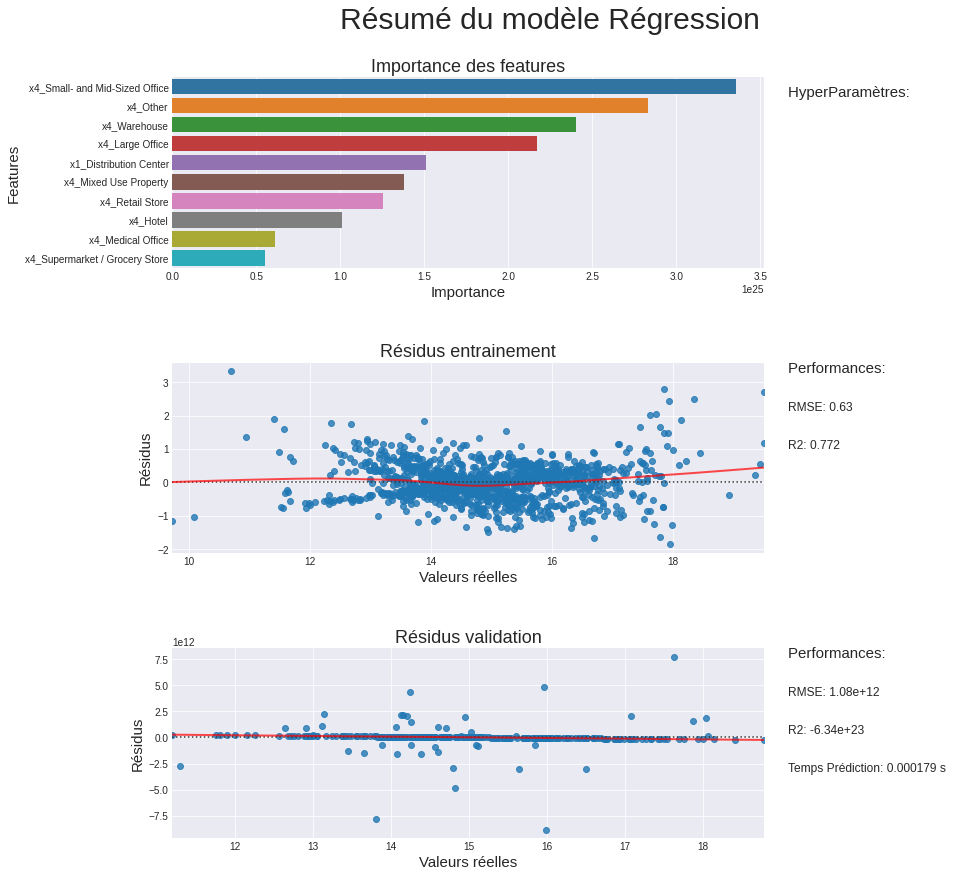

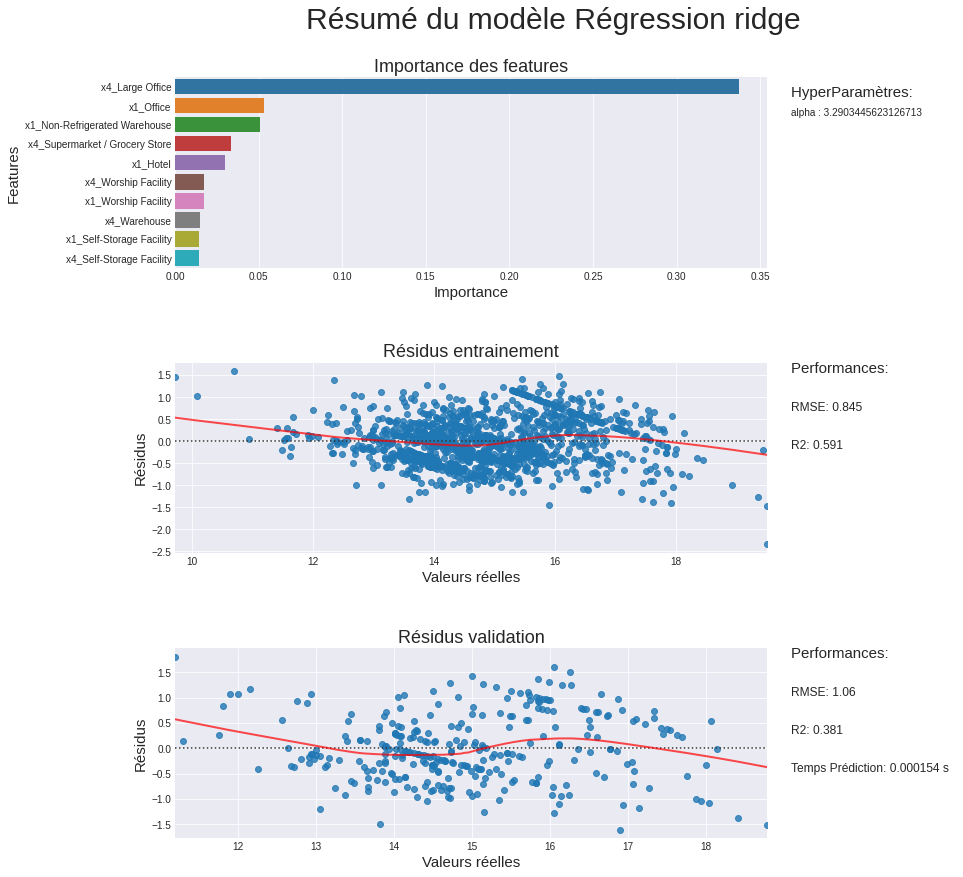

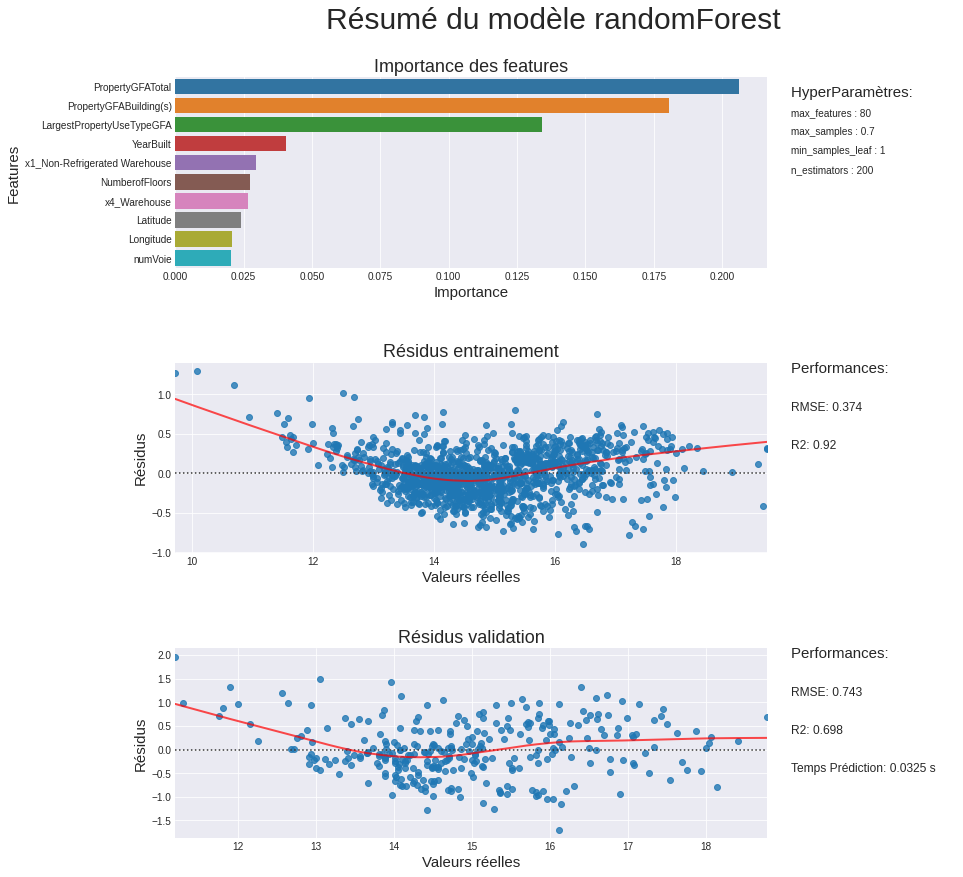

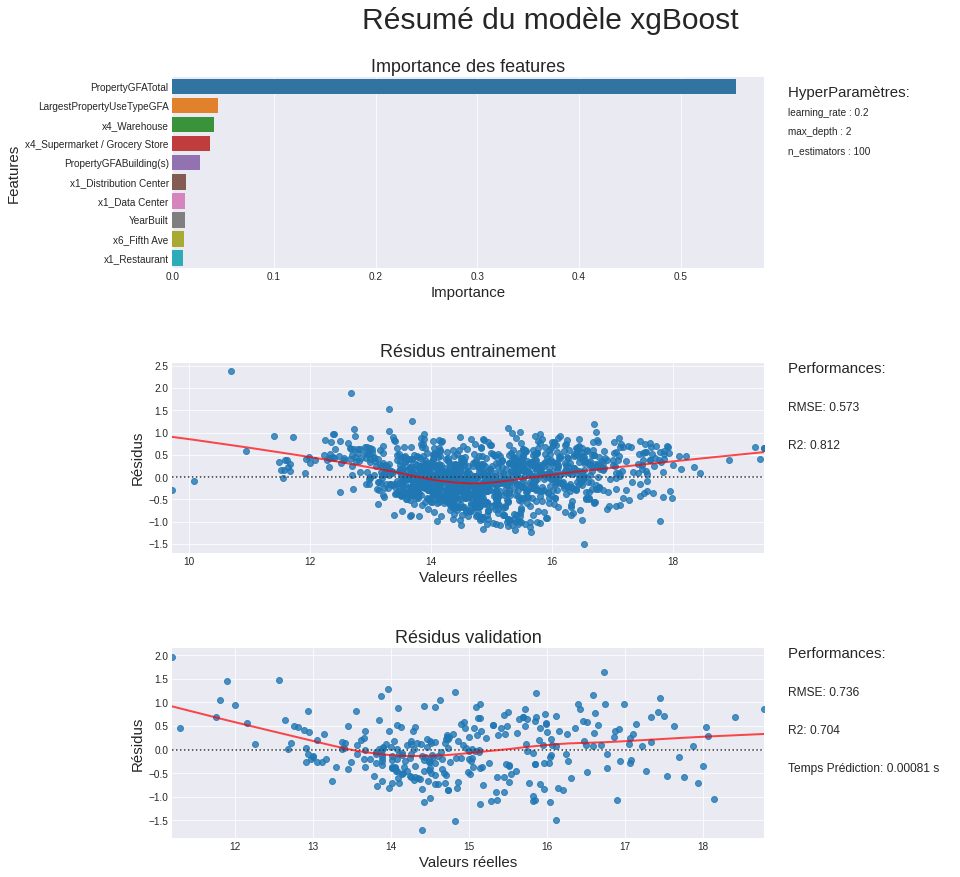

In [827]:
for model in objModelsEnergy:
    model.plot_summary()

Il semble que les modèles aient du mal à prédire les valeurs aux extrémités de la distribution.
- Une possible explication est que la relation consommation / taille d'un batiment ne suffise pas à expliquer certains cas particuliers

## Comparaison des modèles

Nous ajoutons au dataframe de modèles les métriques de leur apprentissage.

In [828]:
modelsDF['RMSEvalidation'] = [objModel.performance['RMSEvalidation'] for objModel in objModelsEnergy ]
modelsDF['R2validation'] = [objModel.performance['R2validation'] for objModel in objModelsEnergy ]
modelsDF['tempsPrediction'] = [objModel.performance['tempsPrediction'] for objModel in objModelsEnergy ]

In [829]:
modelsDF = modelsDF.append({'modelName':'dummyRegressor',
                            'RMSEvalidation':dummyEnergyRMSE,
                            'R2validation':dummyEnergyR2,
                            'tempsPrediction':predictTimeEnergyDummy},
                             ignore_index=True)

Quantité d'erreur

In [830]:
modelsDF.sort_values(by='RMSEvalidation').loc[:,['modelName','RMSEvalidation']]

,modelName,RMSEvalidation
3,xgBoost,7.357469e-01
2,randomForest,7.428393e-01
1,Régression ridge,1.063818e+00
4,dummyRegressor,7.637076e+06
0,Régression,1.076451e+12


Variance expliquée

In [831]:
modelsDF.sort_values(by='R2validation',ascending=False).loc[:,['modelName','R2validation']]

,modelName,R2validation
3,xgBoost,7.039440e-01
2,randomForest,6.982087e-01
1,Régression ridge,3.810550e-01
4,dummyRegressor,-3.314834e+08
0,Régression,-6.337319e+23


Temps de prédiction

In [832]:
modelsDF.sort_values(by='tempsPrediction').loc[:,['modelName','tempsPrediction']]

,modelName,tempsPrediction
1,Régression ridge,0.000154
0,Régression,0.000179
4,dummyRegressor,0.000391
3,xgBoost,0.000810
2,randomForest,0.032523


Nous pouvons conclure que le modèle le plus performant pour la prédiction de consommation d'énergie est xgBoost
- son taux d'erreur est bien inférieur aux modèles linéaires et il explique plus de variance
- ses performances sont à peine supérieures à une forêt aléatoire mais ses prédictions sont beaucoup plus rapides

## Recherche du meilleur modèle : Emissions de gaz à effet de serre

In [833]:
Y_GHGE_train_log = np.log(Y_GHGE_train+1)
Y_GHGE_test_log = np.log(Y_GHGE_test+1)

In [834]:
# "Entrainement" du dummy regressor
dummyGHGE = DummyRegressor(strategy="mean")
dummyGHGE.fit(X_train_encoded,Y_GHGE_train_log)
# mesure du temps de prédiction
starTimeGHGEDummy = timeit.default_timer()
dummyPredictionGHGE = dummyGHGE.predict(X_test_encoded)
predictTimeGHGEDummy =  timeit.default_timer() - starTimeGHGEDummy 
# évatuation des performances
dummyGHGERMSE = np.sqrt(mean_squared_error(Y_GHGE_test_log,dummyPredictionEnergy))
dummyGHGER2 = r2_score(Y_GHGE_test_log,dummyPredictionEnergy)

In [835]:
# Construction du dataframe
modelsDFGHGE = pd.DataFrame({'modelName':modelNames,
                             'model':models,
                             'hyperParameters':hyperParameters})

In [836]:
objModelsGHGE = []
for i in range(0,modelsDFGHGE.shape[0]):
    modelObject = Model(modelsDFGHGE['model'][i],
                        modelsDFGHGE['modelName'][i],
                        X_train_encoded,
                        Y_GHGE_train_log,
                        X_test_encoded,
                        Y_GHGE_test_log,
                        modelsDFGHGE['hyperParameters'][i])
    objModelsGHGE.append(modelObject)

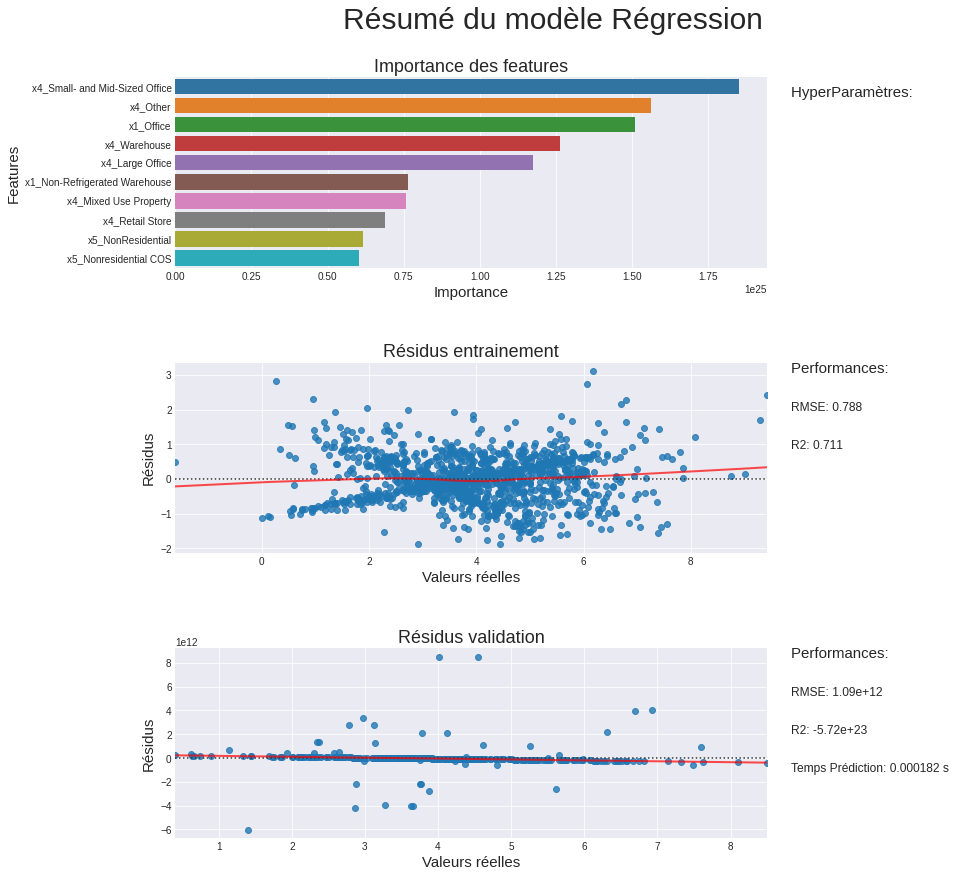

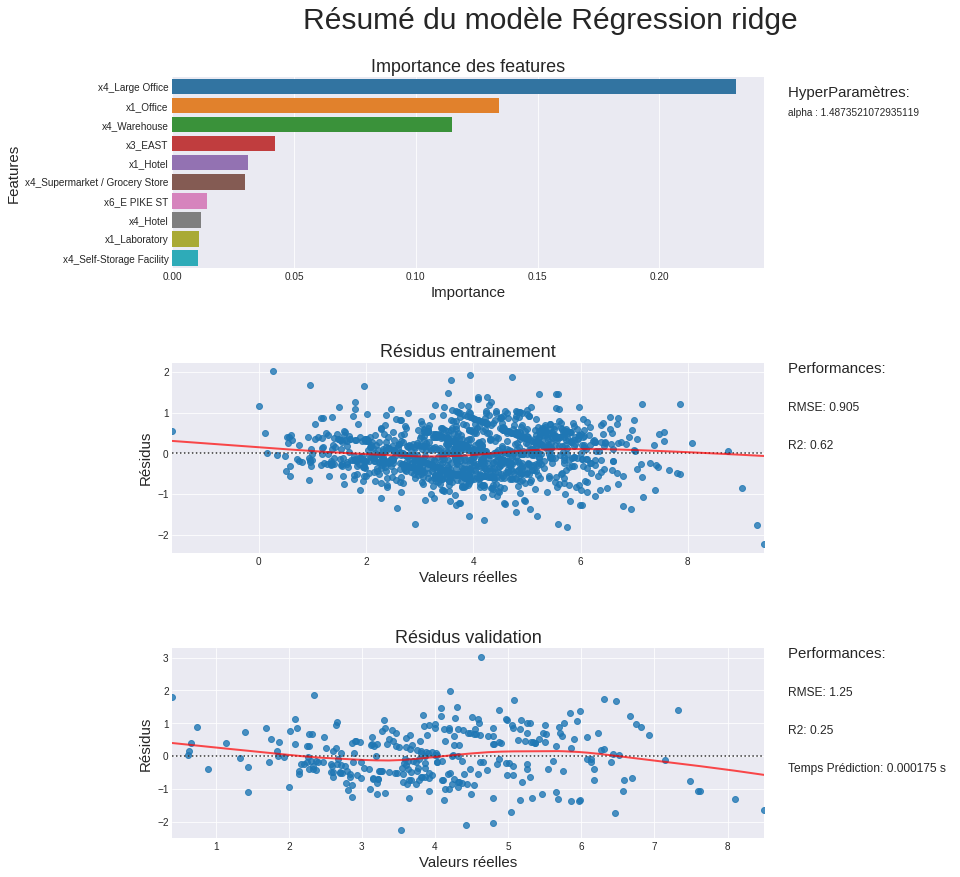

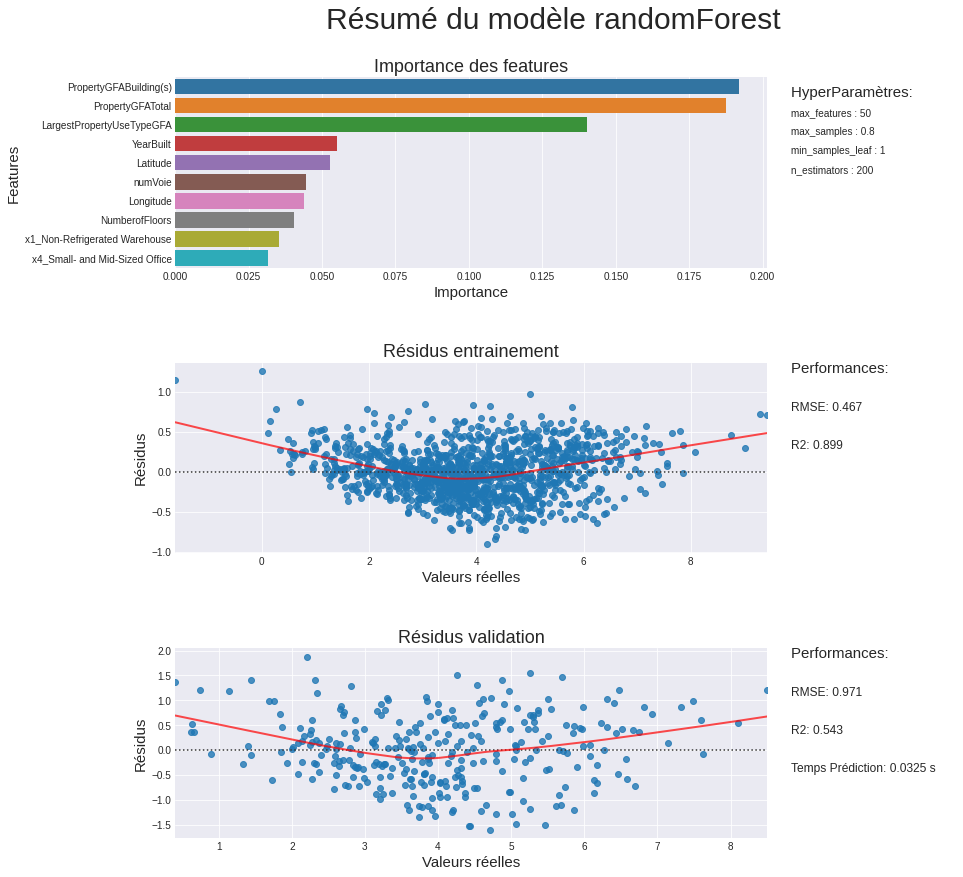

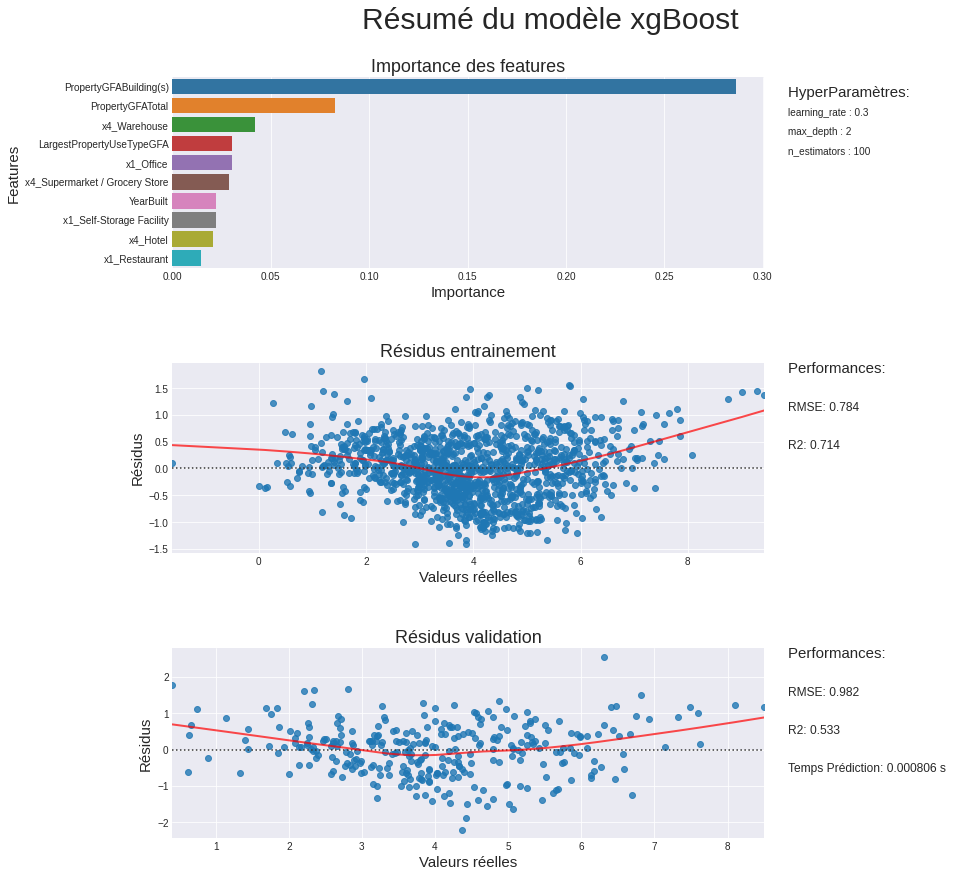

In [837]:
for model in objModelsGHGE:
    model.plot_summary()

In [838]:
modelsDFGHGE['RMSEvalidation'] = [objModel.performance['RMSEvalidation'] for objModel in objModelsGHGE ]
modelsDFGHGE['R2validation'] = [objModel.performance['R2validation'] for objModel in objModelsGHGE ]
modelsDFGHGE['tempsPrediction'] = [objModel.performance['tempsPrediction'] for objModel in objModelsGHGE ]

In [839]:
modelsDFGHGE = modelsDFGHGE.append({'modelName':'dummyRegressor',
                                    'RMSEvalidation':dummyGHGERMSE,
                                    'R2validation':dummyGHGER2,
                                    'tempsPrediction':predictTimeGHGEDummy},
                                     ignore_index=True)

Quantité d'erreur

In [861]:
modelsDFGHGE.sort_values(by='RMSEvalidation').loc[:,['modelName','RMSEvalidation']]

,modelName,RMSEvalidation
2,randomForest,9.714125e-01
3,xgBoost,9.823501e-01
1,Régression ridge,1.245184e+00
4,dummyRegressor,7.637242e+06
0,Régression,1.087297e+12


Variance expliquée

In [841]:
modelsDFGHGE.sort_values(by='R2validation',ascending=False).loc[:,['modelName','R2validation']]

,modelName,R2validation
2,randomForest,5.433953e-01
3,xgBoost,5.330552e-01
1,Régression ridge,2.497599e-01
4,dummyRegressor,-2.822319e+13
0,Régression,-5.720439e+23


Temps de prédiction

In [842]:
modelsDFGHGE.sort_values(by='tempsPrediction').loc[:,['modelName','tempsPrediction']]

,modelName,tempsPrediction
4,dummyRegressor,0.000090
1,Régression ridge,0.000175
0,Régression,0.000182
3,xgBoost,0.000806
2,randomForest,0.032476


Nous pouvons conclure que le modèle RandomForest est le modèle le plus performant pour prédire les émissions de gaz à effet de serre.

Ses performances sont cependant à peine supérieures à xgBoost et son temps de prédiction beaucoup plus long. 
- si le use case du modèle avait nécessité un temps de prédiction rapide, nous aurions porté notre choix sur xgBoost

## Energy Star Score

Nous allons maintenant entrainer deux modèles de la même famille sur deux jeux de données différents:
- Un avec l'energy star score dans ses features
- l'autre sans

En observant la performance de ces deux modèles nous pourrons nous faire une idée du pouvoir prédictif de l'Energy Star Score sur les émissions de gaz à effet de serre.

In [876]:
# Les données chargée depuis le csv ne contiennent pas toute l'energyStar Score
# mettre de coté les valeurs manquantes assure que toutes les lignes comporte le score
energystar = data.dropna()

Separation en train / test, features et validation

In [844]:
trainData, testSet = train_test_split(energystar,
                                      test_size=0.2,
                                      random_state=12)

In [845]:
def cut_X_Y_energystar(data):
    Y_GHGE = data['TotalGHGEmissions']
    X = data.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1)
    return Y_GHGE, X

In [846]:
Y_energystar_train, X_energystar_train = cut_X_Y_energystar(trainData)
Y_energystar_test, X_energystar_test = cut_X_Y_energystar(testSet)

Nous passons au log la target

In [847]:
Y_energystar_train = np.log(Y_energystar_train+1)
Y_energystar_test = np.log(Y_energystar_test+1)

In [848]:
X_nostar_train = X_energystar_train.drop('ENERGYSTARScore',axis=1)
X_nostar_test = X_energystar_test.drop('ENERGYSTARScore',axis=1)

Encodage

In [849]:
encoderStar = ColumnTransformerWithNames([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical_notarget),
    ('ord', OrdinalEncoder(handle_unknown='ignore'), ordinal)
])

In [850]:
X_energystar_train = encoderStar.fit_transform(X_energystar_train)
X_energystar_test = encoderStar.transform(X_energystar_test)

In [851]:
X_nostar_train = encoderStar.fit_transform(X_nostar_train)
X_nostar_test = encoderStar.transform(X_nostar_test)

Entrainement des modèles

In [852]:
NoEnergyStarModel = Model(RandomForestRegressor(),
                          "Sans EnergyStar",
                          X_nostar_train,
                          Y_energystar_train,
                          X_nostar_test,
                          Y_energystar_test,
                          randomForestParameters)

In [853]:
EnergyStarModel = Model(RandomForestRegressor(),
                        "Avec EnergyStar",
                        X_energystar_train,
                        Y_energystar_train,
                        X_energystar_test,
                        Y_energystar_test,
                        randomForestParameters)

In [854]:
print(f"variance expliquée avec l'EnergyStarScore: {EnergyStarModel.performance['R2validation']}")

variance expliquée avec l'EnergyStarScore: 0.6155018747389726


In [855]:
print(f"variance expliquée sans l'EnergyStarScore: {NoEnergyStarModel.performance['R2validation']}")

variance expliquée sans l'EnergyStarScore: 0.604372224713615


La différence est présente mais n'est pas très grande.

### Test de significativité

Nous allons effectuer un test T de student sur les écarts de prédiction de chacun des deux modèles.

Celà nous permettra de déterminer la significativité statistique de la différence entre les prédictions des deux modèles.

In [856]:
diffEnergyStar = np.sqrt((EnergyStarModel.data['YvalPredict'] - Y_energystar_test)**2)
diffnoStar = np.sqrt((NoEnergyStarModel.data['YvalPredict'] - Y_energystar_test)**2)

In [857]:
stats.ttest_ind(diffEnergyStar, diffnoStar)

Ttest_indResult(statistic=-0.08826789991263508, pvalue=0.9297072726888884)

La différence entre les moyennes d'erreur des deux modèles n'a pas montré de significativité.

Les résultats de ce test ne nous permettent pas de prouver l'utilité de l'energyStar Score dans la prédiction des émissions de gaz à effet de serre.